## Import libraries


In [16]:
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

#cross validation
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA


## Load data

In [3]:
### Load data

data = pd.read_csv("default of credit card clients.csv",header=1)

## Data Preprocessing


In [4]:
## Drop irrelavant column

data.drop('ID', axis=1, inplace=True) 

In [5]:
## Rename columns
# SEX can be renamed as GENDER
# PAY_0 can be renamed to PAY_1
# default payment next month can be renamed as DEFAULT_STATUS

data.rename(columns = {'SEX': 'GENDER',
                       'PAY_0':'PAY_1',
                       'default payment next month': 'DEFAULT_STATUS'}, inplace = True) 

In [6]:
## Change -2,-1 in Payment status columns PAY_1 to PAY_6 as 0
## From business point of view, -2: No Consumption, -1: Paid in full, and 0: Use of revolving credit are all good
## Machine learning algo might consider -2,-1 as bad whereas its good. So, converting to 0

Columns=['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

for i in range(len(Columns)):
    data[Columns[i]] = data[Columns[i]].replace(-2,0)
    data[Columns[i]]= data[Columns[i]].replace(-1,0)
    i=i+1

### Label encoding Categorical columns

In [7]:
## Label encoding for modeling
## Label encode Gender and Default status columns

## Create instance, fit to column and transform the values to labels

le = LabelEncoder()
le.fit(data['GENDER'])
data['GENDER'] = le.transform(data['GENDER'])


## Create instance, fit to column and transform the values to labels

LE = LabelEncoder()
LE.fit(data['DEFAULT_STATUS'])
data['DEFAULT_STATUS'] = LE.transform(data['DEFAULT_STATUS'])


### One hot encoding categorical columns

In [8]:
## One hot encoding EDUCATION column

data=pd.get_dummies(data, prefix=['EDUCATION'], columns=['EDUCATION'])

## One hot encode MARRIAGE column

data['MARRIAGE'].replace({1: "Married",
                          2: "Single",
                          3: "Divorced",
                          0: "Others"}, inplace=True)
data=pd.get_dummies(data, prefix=['MARRIAGE'], columns=['MARRIAGE'])

### Correlation matrix


In [9]:
corrmat=data.corr()
corrmat

,LIMIT_BAL,GENDER,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT6,DEFAULT_STATUS,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_Divorced,MARRIAGE_Married,MARRIAGE_Others,MARRIAGE_Single
LIMIT_BAL,1.000000,-0.024755,0.144713,-0.170745,-0.197136,-0.191323,-0.180629,-0.170045,-0.167820,0.285430,...,0.219595,0.153520,0.258777,-0.139686,0.013420,-0.147530,-0.055806,0.103701,-0.011299,-0.090998
GENDER,-0.024755,1.000000,0.090874,0.034475,0.044750,0.041227,0.039737,0.038533,0.032061,0.033642,...,0.002766,-0.039961,0.022750,0.007650,-0.008498,-0.025353,0.001985,-0.030463,-0.011895,0.031004
AGE,0.144713,0.090874,1.000000,-0.001447,-0.008774,-0.014266,-0.007288,-0.013277,-0.016948,0.056239,...,0.019478,-0.013890,-0.100423,0.231252,0.008982,-0.077626,0.082771,0.449425,0.010731,-0.466584
PAY_1,-0.170745,0.034475,-0.001447,1.000000,0.698389,0.516970,0.460224,0.424473,0.373805,-0.000819,...,-0.048733,-0.396019,-0.067995,0.041765,-0.025452,0.040454,0.004147,0.013018,0.000760,-0.013915
PAY_2,-0.197136,0.044750,-0.008774,0.698389,1.000000,0.663529,0.512773,0.462717,0.407086,0.011684,...,-0.043099,-0.327093,-0.083577,0.043848,-0.038173,0.056992,-0.000149,0.009907,0.002666,-0.010084
PAY_3,-0.191323,0.041227,-0.014266,0.516970,0.663529,1.000000,0.678931,0.551430,0.492827,-0.020586,...,-0.048443,-0.286999,-0.071695,0.041790,-0.041272,0.047909,0.004407,-0.001122,0.007540,-0.000433
PAY_4,-0.180629,0.039737,-0.007288,0.460224,0.512773,0.678931,1.000000,0.745419,0.602875,-0.025184,...,-0.048828,-0.269055,-0.068194,0.039355,-0.036438,0.045161,0.004421,0.004442,0.004160,-0.005701
PAY_5,-0.170045,0.038533,-0.013277,0.424473,0.462717,0.551430,0.745419,1.000000,0.740357,-0.018581,...,-0.046110,-0.260850,-0.057303,0.029218,-0.035103,0.041920,-0.004745,0.001728,0.001138,-0.000840
PAY_6,-0.167820,0.032061,-0.016948,0.373805,0.407086,0.492827,0.602875,0.740357,1.000000,-0.019581,...,-0.045358,-0.244437,-0.047115,0.020009,-0.034603,0.038871,0.001724,-0.002308,0.003040,0.001689
BILL_AMT1,0.285430,0.033642,0.056239,-0.000819,0.011684,-0.020586,-0.025184,-0.018581,-0.019581,1.000000,...,0.179341,0.019644,-0.024045,-0.022006,0.036364,0.030323,-0.011401,0.025264,-0.017775,-0.021347


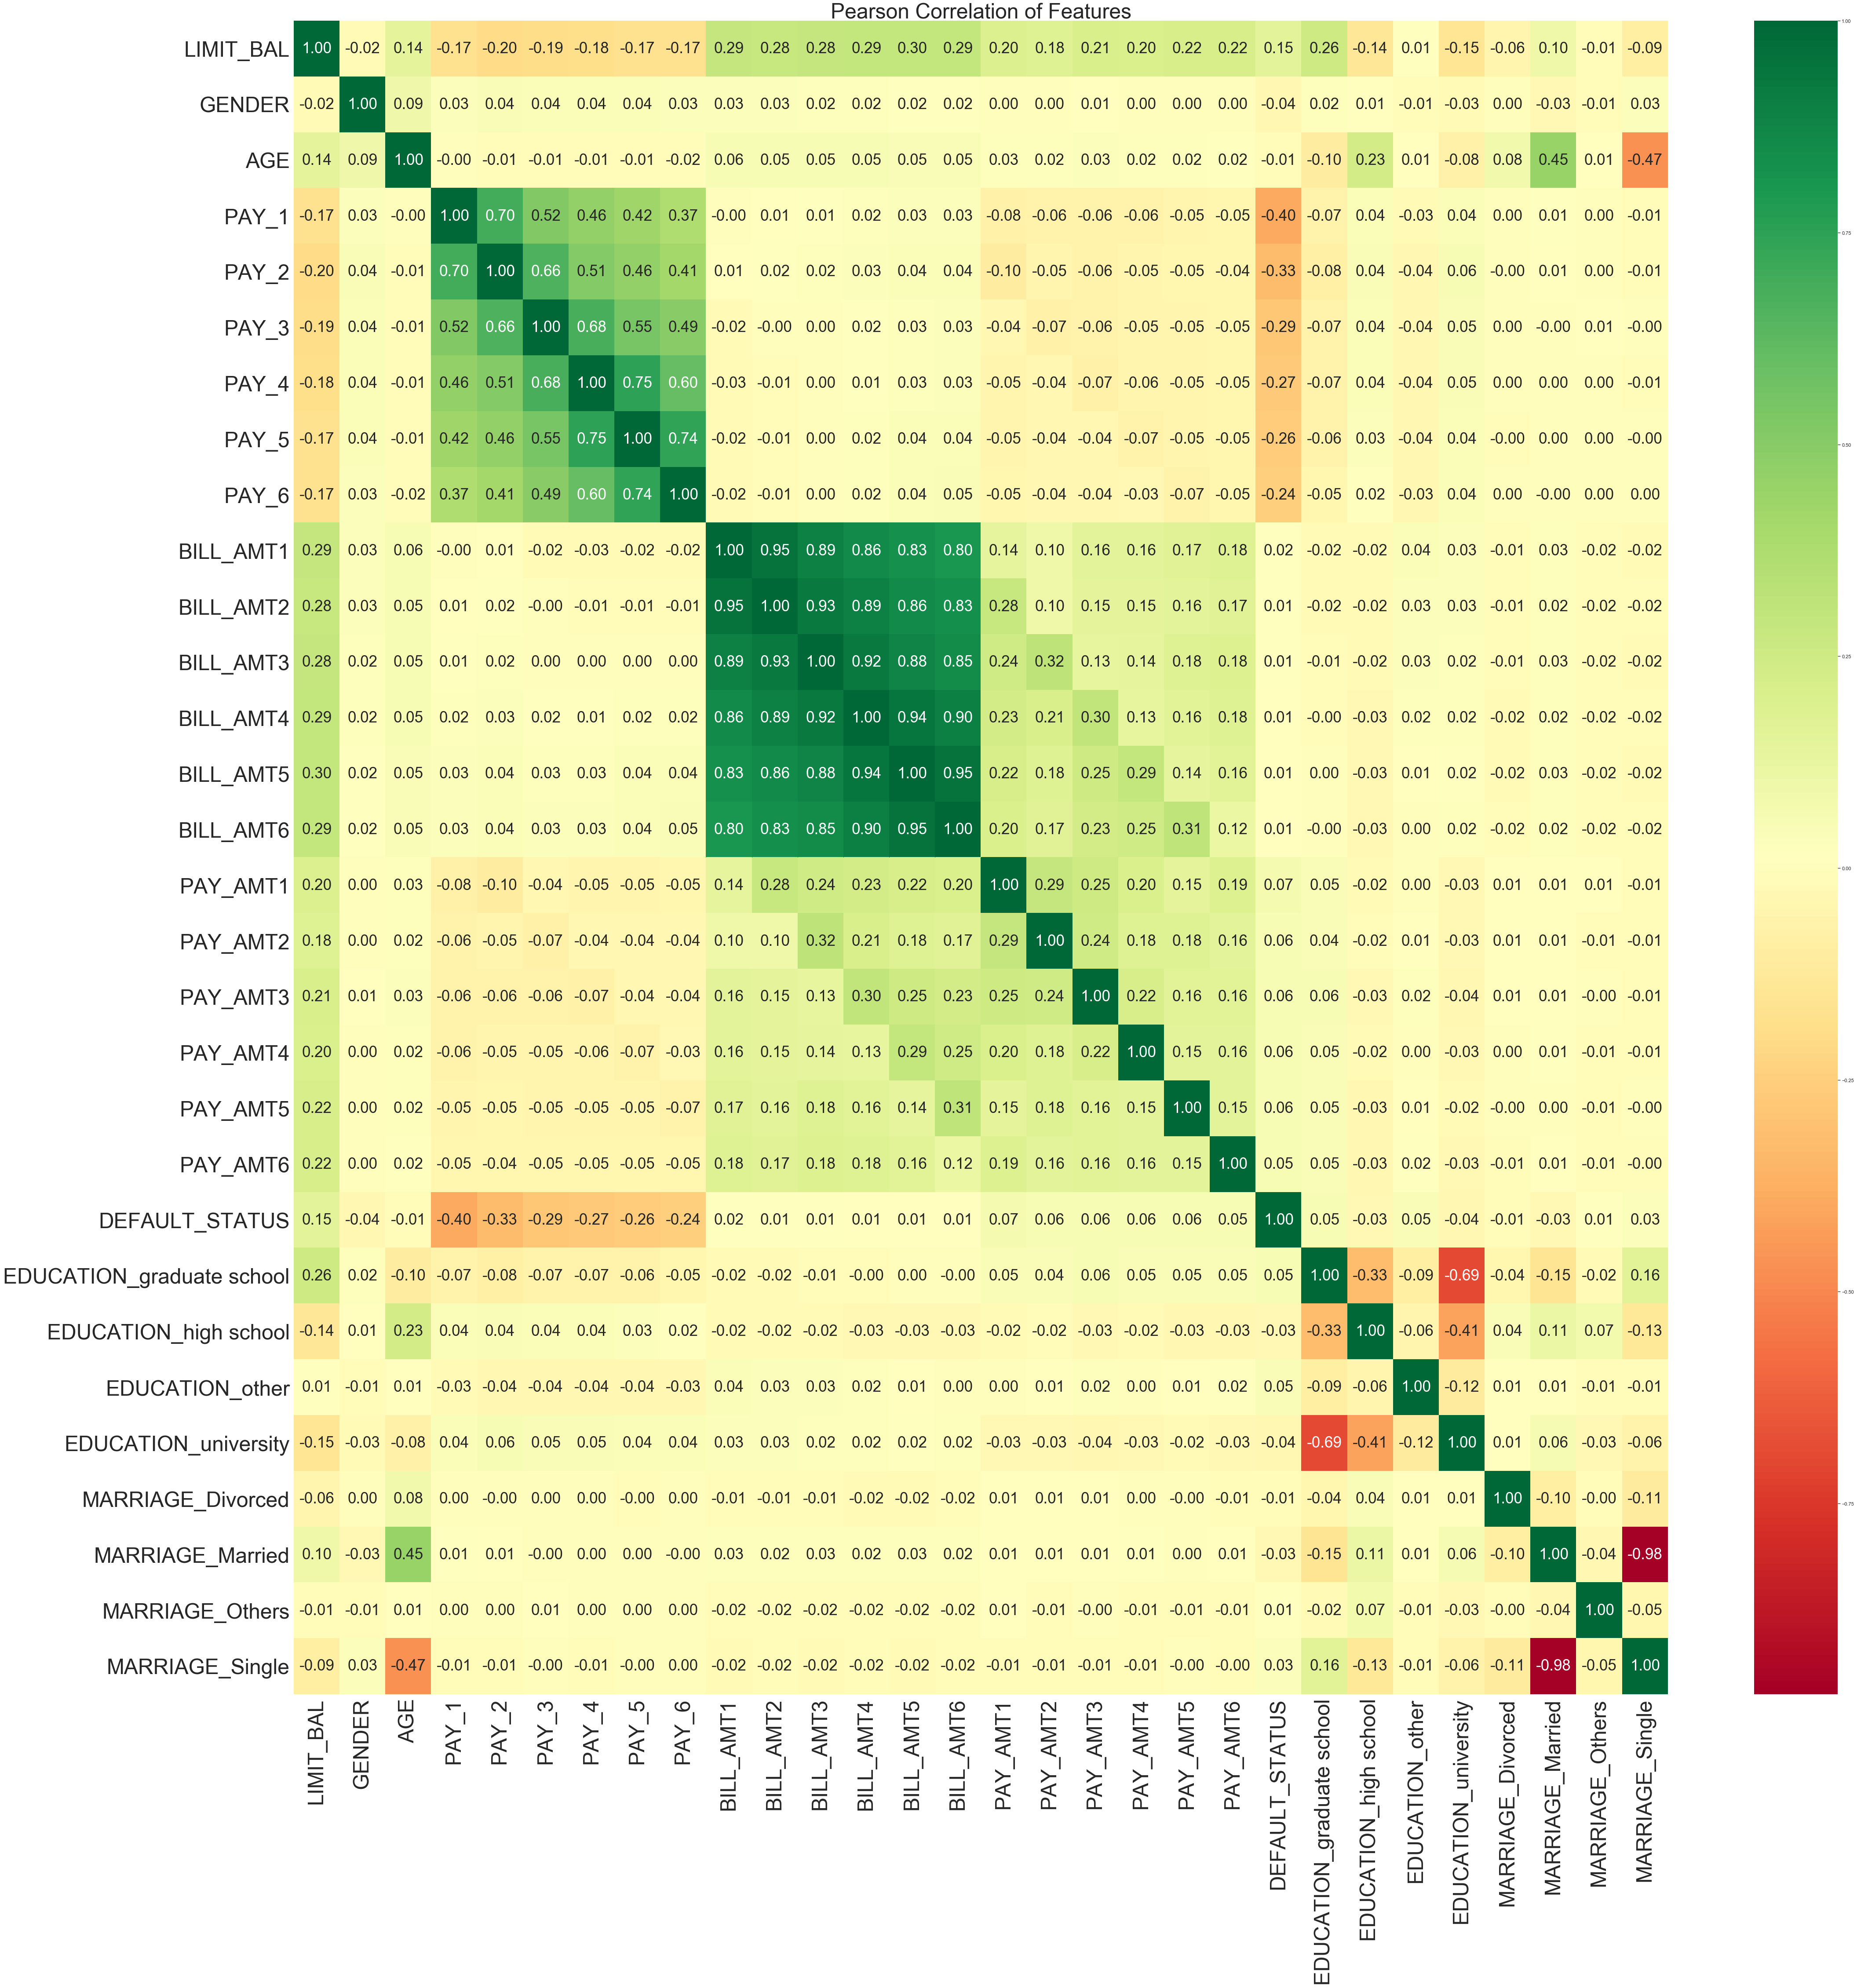

In [10]:
## Visualize the Correlation matrix

# Configure x and y axis
sns.set()
plt.figure(figsize=(70,70))
plt.xticks(fontsize=48)
plt.yticks(fontsize=48)
plt.title('Pearson Correlation of Features', size =48)

# Plotting the data using heatmap
g = sns.heatmap(corrmat,annot=True,cmap="RdYlGn",annot_kws={"size": 35},fmt=".2f")

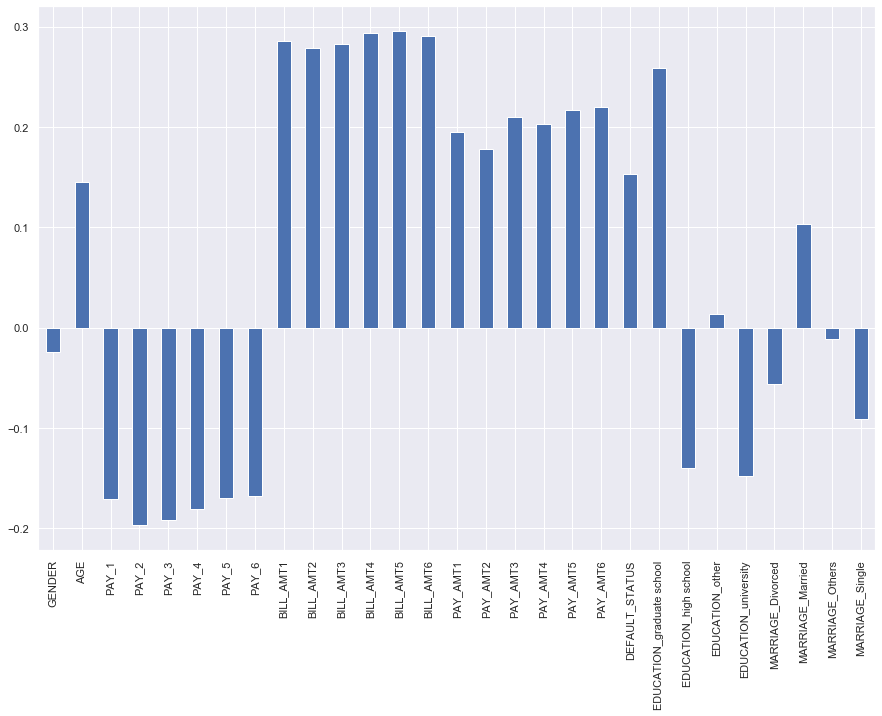

In [11]:
## Pairwise correlation with Target Variable

Limit_bal_corr = corrmat.iloc[0,1:]
Limit_bal_corr.plot(kind='bar',figsize=(15,10))

## Feature Engineering using PCA

### Train test split

In [17]:
X = data.iloc[:,1:]
y = data['LIMIT_BAL']


In [18]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=123)

###  Scaling the training and test data before applying PCA

In [19]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Applying PCA

In [20]:
pca = PCA(.98)

pca.fit(X_train)

pca.n_components_


22

### Splitting new PCA Components to train and test set

In [21]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

### Cross validation

In [22]:
print(cross_val_score(SVR(C=100000), X_train, y_train, cv=10,scoring='r2')) 

[0.42991237 0.38190334 0.3946364  0.42881992 0.40112026 0.37288364
 0.39283329 0.42906654 0.3740227  0.43334752]


### Training the data

In [23]:
algo= SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

model=algo.fit(X_train,y_train)


### Predict the test data

In [24]:
predictions = model.predict(X_test)

### Assess the metrics

In [25]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test,predictions)

print('R Squared of SVR: %.3f' % r2)
print('RMSE of SVR: %.3f' % rmse)  

R Squared of SVR: 0.411
RMSE of SVR: 98749.952


### R2 score of Support vector Regression after PCA is 41.1

### Visualizing the fit

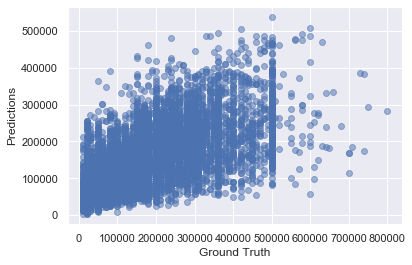

In [26]:
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show();

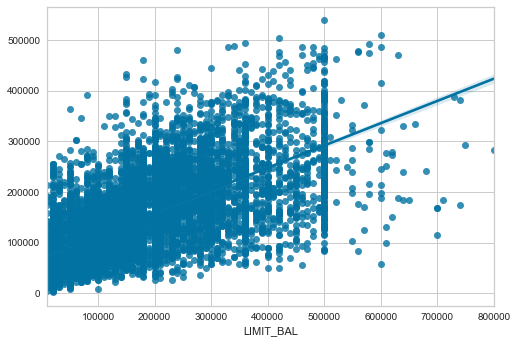

In [29]:
sns.regplot(x=y_test,y=predictions)

C:\Users\PriyaSriram\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


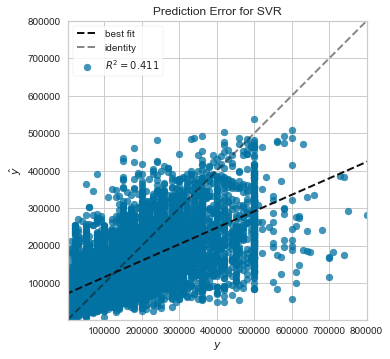

In [28]:
from yellowbrick.regressor import PredictionError
model = PredictionError(SVR(C=100000))
model.fit(X_train, y_train)
model.score(X_test, y_test)
model.show()